# CoDA multi-run metrics (deterministic Markov ground-truths)

In [15]:

import numpy as np
import matplotlib.pyplot as plt
from typing import List

from spatial_environments import GridEnvRightDownNoSelf, GridEnvRightDownNoCue
from util import generate_dataset, generate_dataset_post_augmentation
from coda_metrics import kl_over_time, entropy_over_time, markovization_score
from coda_trial_by_trial_util import CoDAAgent, CoDAConfig


In [16]:

N_SEEDS   = 10
SEED0     = 0
N_ACQ     = 500
N_EXT     = 500
MAX_STEPS = 20
CUE       = 5
    # theta_split=0.6, theta_merge=0.5,
    # n_threshold=8, min_presence_episodes=3, min_effective_exposure=5.0,
    # confidence=0.8, 
    # count_decay=0.9, 
cfg = CoDAConfig(
    theta_split=0.6, theta_merge=0.6,
    n_threshold=8, min_presence_episodes=3, min_effective_exposure=5.0,
    confidence=0.8,
    count_decay=0.9, trace_decay=0.99, retro_decay=0.99
)


In [17]:

def _n_actions(env):
    return max(a for acts in env.valid_actions.values() for a in acts) + 1

def _base_successor(env, s, a):
    i, j  = env.state_to_pos[s]
    di, dj = env.base_actions[a]
    ni, nj = i + di, j + dj
    return env.pos_to_state.get((ni, nj), s)

def _build_base_T(env):
    S0 = env.num_unique_states
    A  = _n_actions(env)
    T  = np.zeros((S0, A, S0), dtype=float)
    terminals = set(env.rewarded_terminals) | set(env.unrewarded_terminals)
    for s, acts in env.valid_actions.items():
        if s in terminals: 
            continue
        for a in acts:
            sp = _base_successor(env, s, a)
            T[s, a, sp] = 1.0
    return T

def _descendants_until_terminal(env, start, terminals):
    adj = {s: [_base_successor(env, s, a) for a in env.valid_actions.get(s, [])]
           for s in range(env.num_unique_states)}
    seen, Q = set(), [start]
    while Q:
        s = Q.pop(0)
        for sp in adj.get(s, []):
            if sp in terminals: 
                continue
            if sp not in seen:
                seen.add(sp); Q.append(sp)
    return seen

def build_gt_acquisition_with_clones(env, cue_state: int) -> np.ndarray:
    S0 = env.num_unique_states
    A  = _n_actions(env)
    T0 = _build_base_T(env)

    terminals = set(env.rewarded_terminals) | set(env.unrewarded_terminals)
    rewT = env.rewarded_terminals
    unrewT = env.unrewarded_terminals

    D = _descendants_until_terminal(env, cue_state, terminals)
    clone_of = {orig: S0 + k for k, orig in enumerate(sorted(D))}
    S = S0 + len(clone_of)
    T = np.zeros((S, A, S), dtype=float)
    T[:S0, :, :S0] = T0

    for a in env.valid_actions[cue_state]:
        sp = _base_successor(env, cue_state, a)
        if sp in D:
            T[cue_state, a, sp] = 0.0
            T[cue_state, a, clone_of[sp]] = 1.0

    for orig, cl in clone_of.items():
        for a in env.valid_actions[orig]:
            sp = _base_successor(env, orig, a)
            if sp in terminals:
                for t in rewT:   T[cl, a, t] = 1.0
                for t in unrewT: T[cl, a, t] = 0.0
            else:
                T[cl, a, clone_of[sp] if sp in clone_of else sp] = 1.0

        for a in env.valid_actions[orig]:
            sp = _base_successor(env, orig, a)
            if sp in rewT:
                T[orig, a, sp] = 0.0
                idx = rewT.index(sp)
                T[orig, a, unrewT[idx]] = 1.0
    return T

def build_gt_extinction_no_clones(env2) -> np.ndarray:
    T = _build_base_T(env2)
    for s in range(env2.num_unique_states):
        for a in env2.valid_actions.get(s, []):
            sp = _base_successor(env2, s, a)
            if sp in env2.rewarded_terminals:
                idx = env2.rewarded_terminals.index(sp)
                T[s, a, sp] = 0.0
                T[s, a, env2.unrewarded_terminals[idx]] = 1.0
    return T

def _pad3(arr: np.ndarray, shape: tuple) -> np.ndarray:
    S, A, S2 = arr.shape
    Sg, Ag, S2g = shape
    if (S, A, S2) == (Sg, Ag, S2g): 
        return arr
    out = np.zeros((Sg, Ag, S2g), dtype=float)
    out[:min(S,Sg), :min(A,Ag), :min(S2,S2g)] = arr[:min(S,Sg), :min(A,Ag), :min(S2,S2g)]
    return out

def _ref_fn_fixed(T_fixed: np.ndarray):
    def _fn(T_learned):
        shape = tuple(max(x,y) for x,y in zip(T_learned.shape, T_fixed.shape))
        return _pad3(T_fixed, shape)
    return _fn


In [18]:

def run_one_seed(seed:int):
    np.random.seed(seed)

    env = GridEnvRightDownNoSelf(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
    T_ref_acq_fixed = build_gt_acquisition_with_clones(env, cue_state=CUE)
    ref_fn_acq = _ref_fn_fixed(T_ref_acq_fixed)

    agent = CoDAAgent(env, cfg)

    T_series_acq: List[np.ndarray] = []
    with_clones = False
    for ep in range(1, N_ACQ+1):
        if with_clones:
            (states, actions) = generate_dataset_post_augmentation(env, agent.get_T(), n_episodes=1, max_steps=MAX_STEPS)[0]
        else:
            (states, actions) = generate_dataset(env, n_episodes=1, max_steps=MAX_STEPS)[0]
        agent.update_with_episode(states, actions)
        if agent.maybe_split():
            with_clones = True
        T_series_acq.append(agent.get_T().copy())

    env2 = GridEnvRightDownNoCue(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
    env2.clone_dict = dict(getattr(env, "clone_dict", {}))
    env2.reverse_clone_dict = dict(getattr(env, "reverse_clone_dict", {}))
    agent.env = env2

    T_ref_ext_fixed = build_gt_extinction_no_clones(env2)
    ref_fn_ext = _ref_fn_fixed(T_ref_ext_fixed)

    T_series_ext: List[np.ndarray] = []
    for ep in range(N_ACQ+1, N_ACQ+N_EXT+1):
        (states, actions) = generate_dataset_post_augmentation(env2, agent.get_T(), n_episodes=1, max_steps=MAX_STEPS)[0]
        agent.update_with_episode(states, actions)
        agent.maybe_merge()
        T_series_ext.append(agent.get_T().copy())

    KL_acq = kl_over_time(T_series_acq, ref_fn_acq, use_js=False)
    JS_acq = kl_over_time(T_series_acq, ref_fn_acq, use_js=True)
    H_acq  = entropy_over_time(T_series_acq)
    MS_acq = np.array([markovization_score(T) for T in T_series_acq])

    KL_ext = kl_over_time(T_series_ext, ref_fn_ext, use_js=False)
    JS_ext = kl_over_time(T_series_ext, ref_fn_ext, use_js=True)
    H_ext  = entropy_over_time(T_series_ext)
    MS_ext = np.array([markovization_score(T) for T in T_series_ext])

    return dict(KL_acq=KL_acq, JS_acq=JS_acq, H_acq=H_acq, MS_acq=MS_acq,
                KL_ext=KL_ext, JS_ext=JS_ext, H_ext=H_ext, MS_ext=MS_ext)


In [19]:

results = []
for k in range(N_SEEDS):
    results.append(run_one_seed(SEED0 + k))

def _pad_stack(arrs):
    L = max(len(a) for a in arrs)
    M = np.full((len(arrs), L), np.nan)
    for i,a in enumerate(arrs):
        M[i,:len(a)] = a
    return M

def mean_se(arrs):
    M = _pad_stack(arrs)
    mean = np.nanmean(M, axis=0)
    se   = np.nanstd(M, axis=0, ddof=max(1,min(len(arrs)-1,1))) / np.sqrt(max(1,len(arrs)))
    return mean, se

KL_acq_runs = [r["KL_acq"] for r in results]
JS_acq_runs = [r["JS_acq"] for r in results]
H_acq_runs  = [r["H_acq"]  for r in results]
MS_acq_runs = [r["MS_acq"] for r in results]

KL_ext_runs = [r["KL_ext"] for r in results]
JS_ext_runs = [r["JS_ext"] for r in results]
H_ext_runs  = [r["H_ext"]  for r in results]
MS_ext_runs = [r["MS_ext"] for r in results]


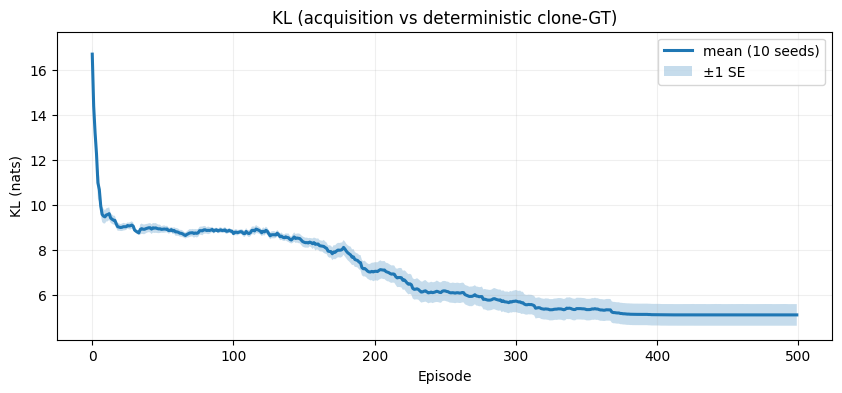

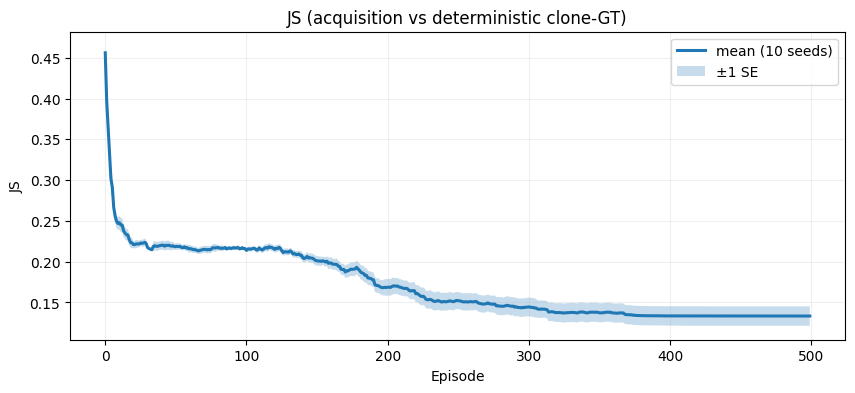

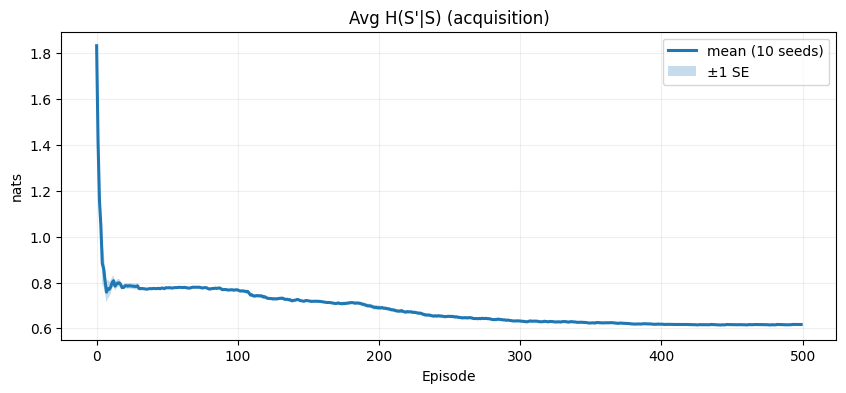

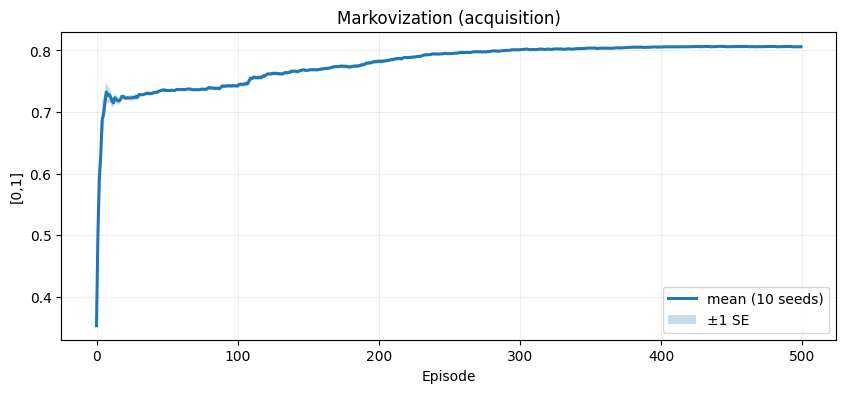

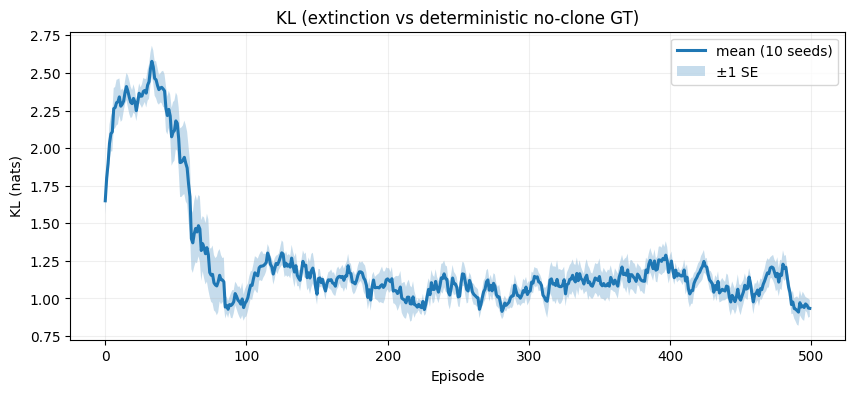

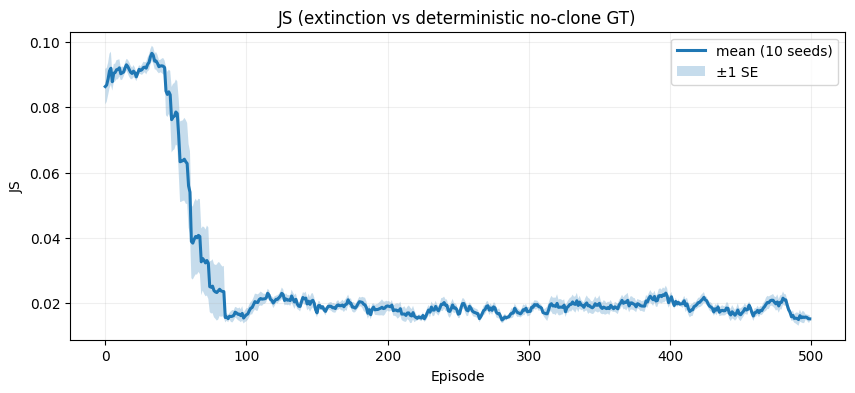

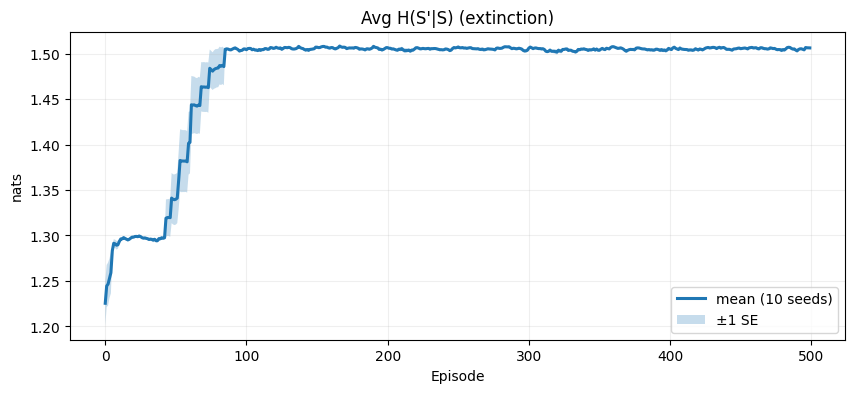

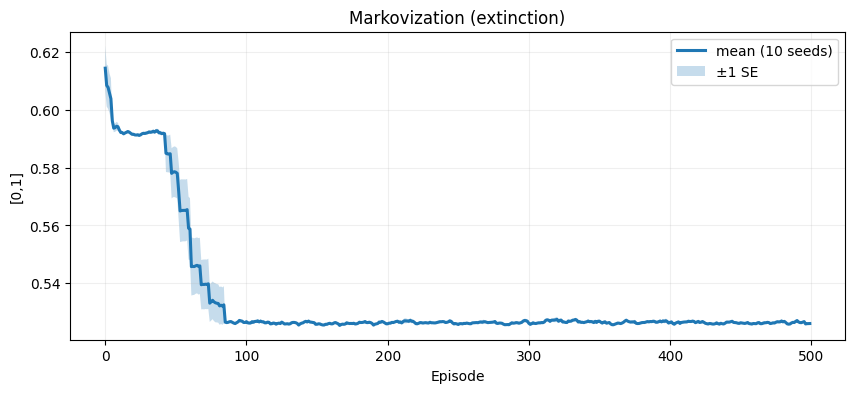

In [20]:

def plot_band(y_runs, title, ylabel):
    mean, se = mean_se(y_runs)
    x = np.arange(len(mean))
    plt.plot(x, mean, lw=2.2, label=f"mean ({len(y_runs)} seeds)")
    plt.fill_between(x, mean-se, mean+se, alpha=0.25, label="±1 SE")
    plt.title(title); plt.xlabel("Episode"); plt.ylabel(ylabel); plt.legend(); plt.grid(alpha=0.2)

plt.figure(figsize=(10,4)); plot_band(KL_acq_runs, "KL (acquisition vs deterministic clone-GT)", "KL (nats)"); plt.show()
plt.figure(figsize=(10,4)); plot_band(JS_acq_runs, "JS (acquisition vs deterministic clone-GT)", "JS"); plt.show()
plt.figure(figsize=(10,4)); plot_band(H_acq_runs,  "Avg H(S'|S) (acquisition)", "nats"); plt.show()
plt.figure(figsize=(10,4)); plot_band(MS_acq_runs, "Markovization (acquisition)", "[0,1]"); plt.show()

plt.figure(figsize=(10,4)); plot_band(KL_ext_runs, "KL (extinction vs deterministic no-clone GT)", "KL (nats)"); plt.show()
plt.figure(figsize=(10,4)); plot_band(JS_ext_runs, "JS (extinction vs deterministic no-clone GT)", "JS"); plt.show()
plt.figure(figsize=(10,4)); plot_band(H_ext_runs,  "Avg H(S'|S) (extinction)", "nats"); plt.show()
plt.figure(figsize=(10,4)); plot_band(MS_ext_runs, "Markovization (extinction)", "[0,1]"); plt.show()


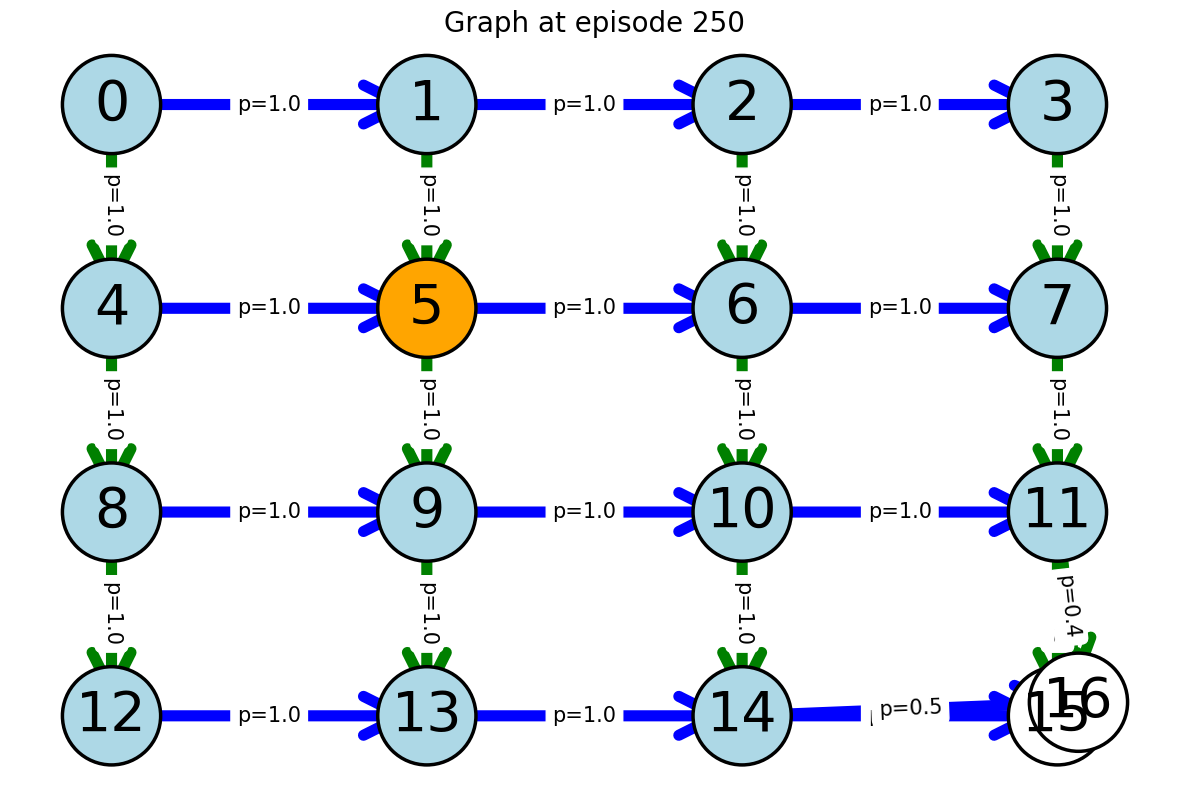

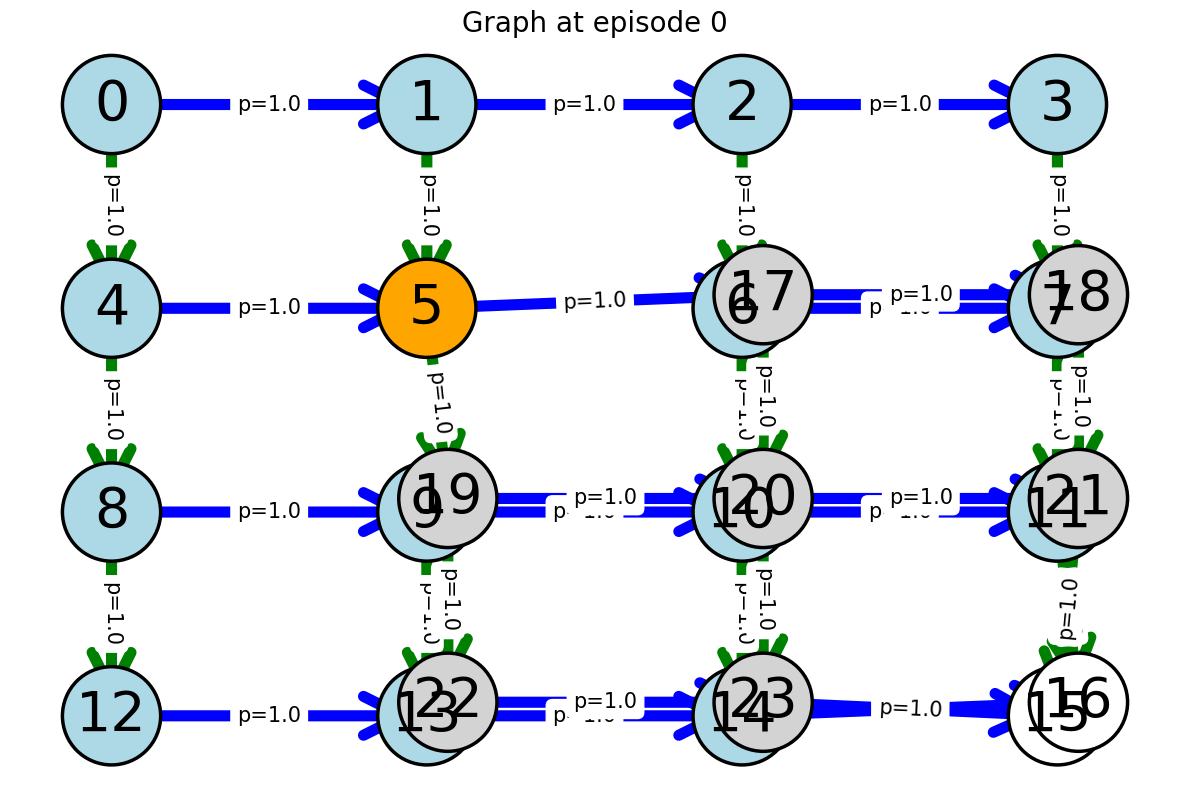

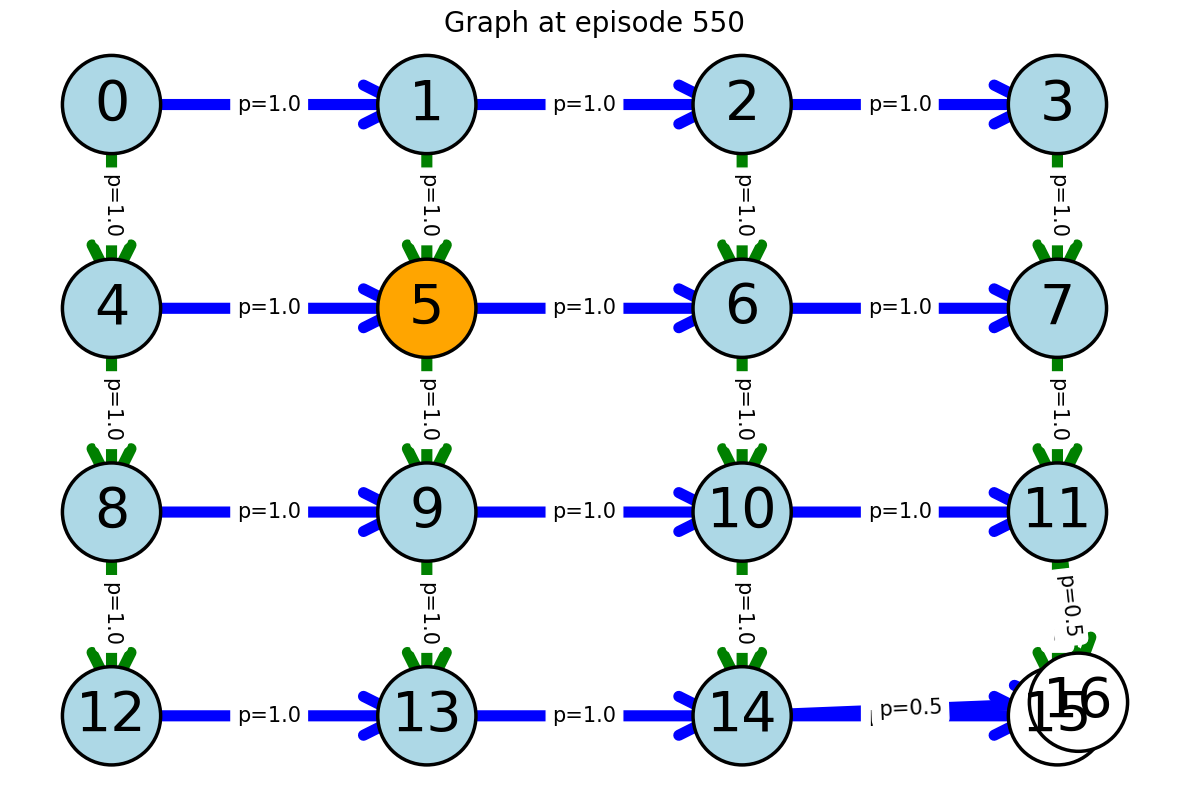

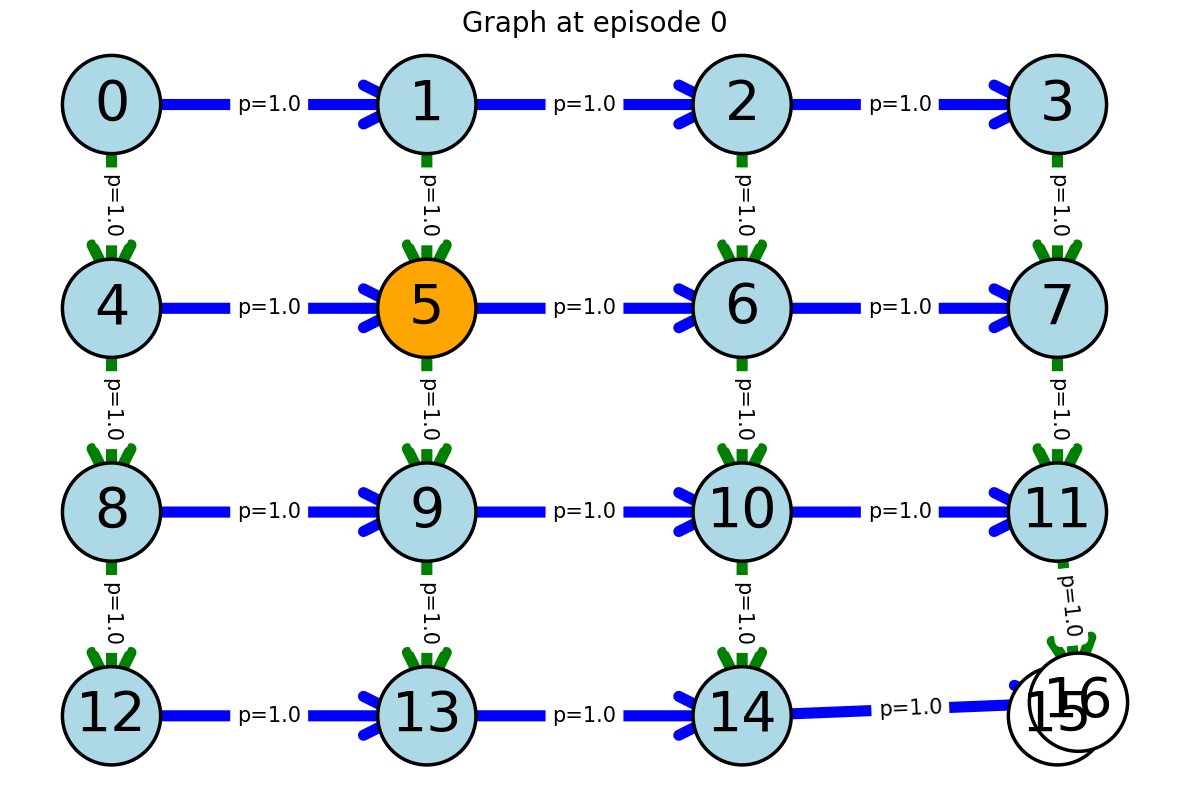

In [21]:
# ===== Visualize final learned vs deterministic ground-truth (one seed) =====
import numpy as np

from spatial_environments import GridEnvRightDownNoSelf, GridEnvRightDownNoCue
from util import generate_dataset, generate_dataset_post_augmentation
from coda_trial_by_trial_util import CoDAAgent, CoDAConfig

# ---------- minimal helpers ----------
def _n_actions(env):
    return max(a for acts in env.valid_actions.values() for a in acts) + 1

def _base_successor(env, s, a):
    i, j  = env.state_to_pos[s]
    di, dj = env.base_actions[a]
    ni, nj = i + di, j + dj
    return env.pos_to_state.get((ni, nj), s)

def _build_base_T(env):
    S0 = env.num_unique_states
    A  = _n_actions(env)
    T  = np.zeros((S0, A, S0), dtype=float)
    terminals = set(env.rewarded_terminals) | set(env.unrewarded_terminals)
    for s, acts in env.valid_actions.items():
        if s in terminals: 
            continue
        for a in acts:
            sp = _base_successor(env, s, a)
            T[s, a, sp] = 1.0
    return T

def _descendants_until_terminal(env, start, terminals):
    adj = {s: [_base_successor(env, s, a) for a in env.valid_actions.get(s, [])]
           for s in range(env.num_unique_states)}
    seen, Q = set(), [start]
    while Q:
        s = Q.pop(0)
        for sp in adj.get(s, []):
            if sp in terminals: 
                continue
            if sp not in seen:
                seen.add(sp); Q.append(sp)
    return seen

def _pad3(arr: np.ndarray, shape: tuple) -> np.ndarray:
    S, A, S2 = arr.shape
    Sg, Ag, S2g = shape
    if (S, A, S2) == (Sg, Ag, S2g): 
        return arr
    out = np.zeros((Sg, Ag, S2g), dtype=float)
    out[:min(S,Sg), :min(A,Ag), :min(S2,S2g)] = arr[:min(S,Sg), :min(A,Ag), :min(S2,S2g)]
    return out

def make_terminals_absorbing_for_plot(T, terminals):
    T = T.copy()
    for t in terminals:
        if t < T.shape[0]:
            T[t, :, :] = 0.0
    return T

def sanitize_for_plot(env, T, eps=1e-12):
    if T is None or getattr(T, "ndim", 0) != 3: return
    S = T.shape[0]
    out_mass = T.sum(axis=(1,2))
    in_mass  = T.sum(axis=(0,1))
    active = (out_mass + in_mass) > eps
    for cl in list(getattr(env, "clone_dict", {}).keys()):
        if cl >= S or not active[cl]:
            env.clone_dict.pop(cl, None)
    env.reverse_clone_dict = {parent: cl for cl, parent in env.clone_dict.items()}

# ---------- deterministic (0/1) ground-truth builders ----------
def build_gt_acquisition_with_clones(env, cue_state: int):
    """
    Deterministic GT for acquisition:
      - clone all descendants of the cue (until terminal)
      - cue→descendant edges go to clones; transitions within branch stay among clones
      - clone→terminal = rewarded; original pre-terminal→paired unrewarded
    Returns: (T_gt, clone_dict, reverse_clone_dict)
    """
    S0 = env.num_unique_states
    A  = _n_actions(env)
    T0 = _build_base_T(env)
    terminals = set(env.rewarded_terminals) | set(env.unrewarded_terminals)
    rewT = env.rewarded_terminals
    unrewT = env.unrewarded_terminals

    D = _descendants_until_terminal(env, cue_state, terminals)
    clone_of = {orig: S0 + k for k, orig in enumerate(sorted(D))}
    S = S0 + len(clone_of)
    T = np.zeros((S, A, S), dtype=float)
    T[:S0, :, :S0] = T0

    # cue redirection
    for a in env.valid_actions[cue_state]:
        sp = _base_successor(env, cue_state, a)
        if sp in D:
            T[cue_state, a, sp] = 0.0
            T[cue_state, a, clone_of[sp]] = 1.0

    # clone branch and original pre-term rules
    for orig, cl in clone_of.items():
        for a in env.valid_actions[orig]:
            sp = _base_successor(env, orig, a)
            if sp in terminals:
                for t in rewT:   T[cl, a, t] = 1.0     # clone → rewarded
                for t in unrewT: T[cl, a, t] = 0.0
            else:
                T[cl, a, clone_of[sp] if sp in clone_of else sp] = 1.0

        # original pre-terminal must not go to rewarded
        for a in env.valid_actions[orig]:
            sp = _base_successor(env, orig, a)
            if sp in rewT:
                T[orig, a, sp] = 0.0
                idx = rewT.index(sp)
                T[orig, a, unrewT[idx]] = 1.0

    clone_dict = {cl: orig for orig, cl in clone_of.items()}
    reverse_clone_dict = {orig: cl for orig, cl in clone_of.items()}
    return T, clone_dict, reverse_clone_dict

def build_gt_extinction_no_clones(env2):
    """
    Deterministic GT for extinction:
      - base deterministic transitions
      - any s→rewarded-terminal is redirected to the paired UNREWARDED terminal
      - no clones
    """
    T = _build_base_T(env2)
    for s in range(env2.num_unique_states):
        for a in env2.valid_actions.get(s, []):
            sp = _base_successor(env2, s, a)
            if sp in env2.rewarded_terminals:
                idx = env2.rewarded_terminals.index(sp)
                T[s, a, sp] = 0.0
                T[s, a, env2.unrewarded_terminals[idx]] = 1.0
    return T

# ---------- user knobs ----------
SEED      = 7
N_ACQ     = 250
N_EXT     = 300
MAX_STEPS = 20
CUE       = 5
THRESH_LEARNED = 0.30   # your usual threshold
THRESH_GT      = 0.05   # use lower threshold for GT so every edge renders

cfg = CoDAConfig(
    theta_split=0.9, theta_merge=0.5,
    n_threshold=8, min_presence_episodes=8, min_effective_exposure=25.0,
    confidence=0.95,
    count_decay=0.995, trace_decay=0.99, retro_decay=0.99
)

np.random.seed(SEED)

# ---------- 1) Run acquisition (learned) ----------
env = GridEnvRightDownNoSelf(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
agent = CoDAAgent(env, cfg)

with_clones = False
for ep in range(1, N_ACQ+1):
    if with_clones:
        (states, actions) = generate_dataset_post_augmentation(env, agent.get_T(), n_episodes=1, max_steps=MAX_STEPS)[0]
    else:
        (states, actions) = generate_dataset(env, n_episodes=1, max_steps=MAX_STEPS)[0]
    agent.update_with_episode(states, actions)
    if agent.maybe_split():
        with_clones = True

T_acq_final = agent.get_T().copy()

# ---------- 2) Build acquisition GT (clone-aware) ----------
env_acq_gt = GridEnvRightDownNoSelf(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
T_ref_acq, clone_dict_acq, reverse_clone_dict_acq = build_gt_acquisition_with_clones(env_acq_gt, cue_state=CUE)
env_acq_gt.clone_dict = clone_dict_acq
env_acq_gt.reverse_clone_dict = reverse_clone_dict_acq

# ---------- 3) Switch to extinction, continue learning ----------
env2 = GridEnvRightDownNoCue(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
env2.clone_dict = dict(getattr(env, "clone_dict", {}))
env2.reverse_clone_dict = dict(getattr(env, "reverse_clone_dict", {}))
agent.env = env2

for ep in range(N_ACQ+1, N_ACQ+N_EXT+1):
    (states, actions) = generate_dataset_post_augmentation(env2, agent.get_T(), n_episodes=1, max_steps=MAX_STEPS)[0]
    agent.update_with_episode(states, actions)
    agent.maybe_merge()

T_ext_final = agent.get_T().copy()

# ---------- 4) Build extinction GT (no clones; all → unrewarded) ----------
env_ext_gt = GridEnvRightDownNoCue(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
T_ref_ext = build_gt_extinction_no_clones(env_ext_gt)

# ---------- 5) Pad shapes and tidy for figure ----------
shape_acq = tuple(max(x,y) for x,y in zip(T_acq_final.shape, T_ref_acq.shape))
T_acq_final = _pad3(T_acq_final, shape_acq)
T_ref_acq   = _pad3(T_ref_acq,   shape_acq)

shape_ext = tuple(max(x,y) for x,y in zip(T_ext_final.shape, T_ref_ext.shape))
T_ext_final = _pad3(T_ext_final, shape_ext)
T_ref_ext   = _pad3(T_ref_ext,   shape_ext)

T_acq_vis     = make_terminals_absorbing_for_plot(T_acq_final, env.rewarded_terminals + env.unrewarded_terminals)
T_ref_acq_vis = make_terminals_absorbing_for_plot(T_ref_acq,   env_acq_gt.rewarded_terminals + env_acq_gt.unrewarded_terminals)
T_ext_vis     = make_terminals_absorbing_for_plot(T_ext_final, env2.rewarded_terminals + env2.unrewarded_terminals)
T_ref_ext_vis = make_terminals_absorbing_for_plot(T_ref_ext,   env_ext_gt.rewarded_terminals + env_ext_gt.unrewarded_terminals)

sanitize_for_plot(env,  T_acq_vis)
sanitize_for_plot(env2, T_ext_vis)

# ---------- 6) Plot the four panels ----------
env.plot_graph(T_acq_vis,            niter=N_ACQ,            threshold=THRESH_LEARNED, save=False, savename=f"seed{SEED}_acq_learned.png")
env_acq_gt.plot_graph(T_ref_acq_vis, niter=0,                threshold=THRESH_GT,      save=False, savename=f"seed{SEED}_acq_GT.png")
env2.plot_graph(T_ext_vis,           niter=N_ACQ+N_EXT,      threshold=THRESH_LEARNED, save=False, savename=f"seed{SEED}_ext_learned.png")
env_ext_gt.plot_graph(T_ref_ext_vis, niter=0,                threshold=THRESH_GT,      save=False, savename=f"seed{SEED}_ext_GT.png")

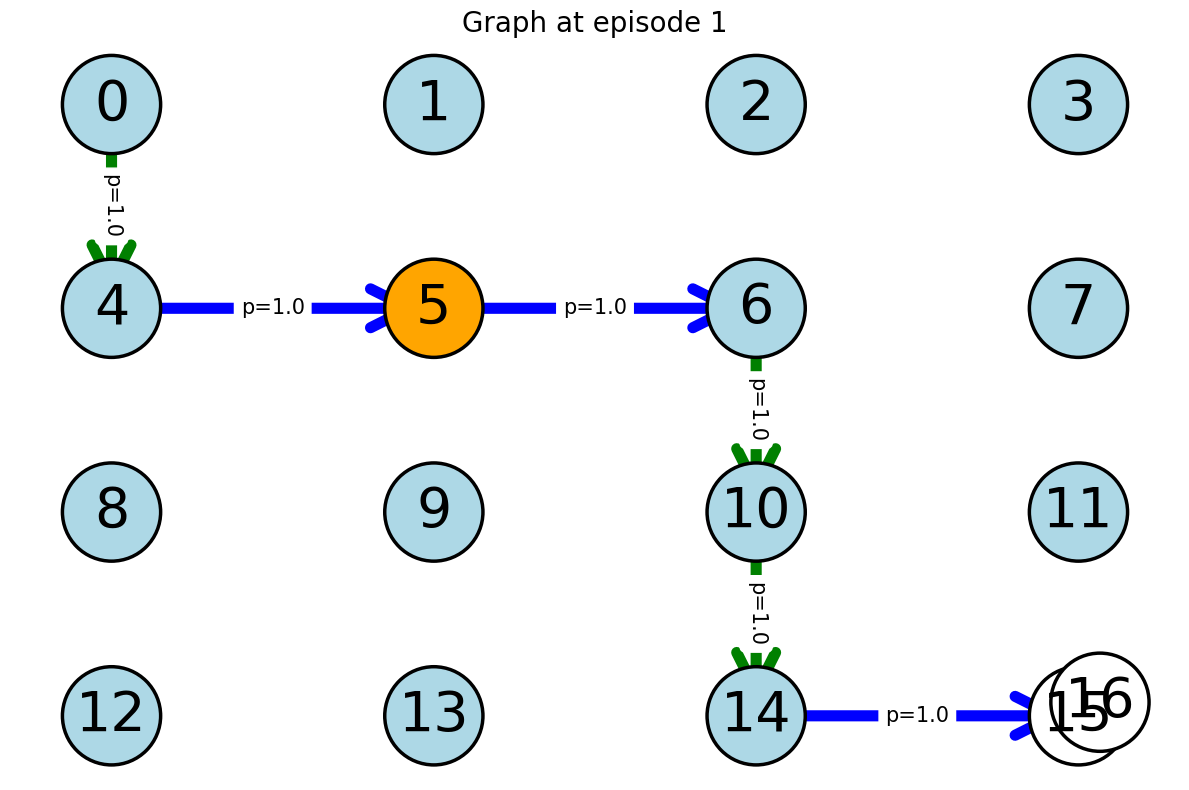

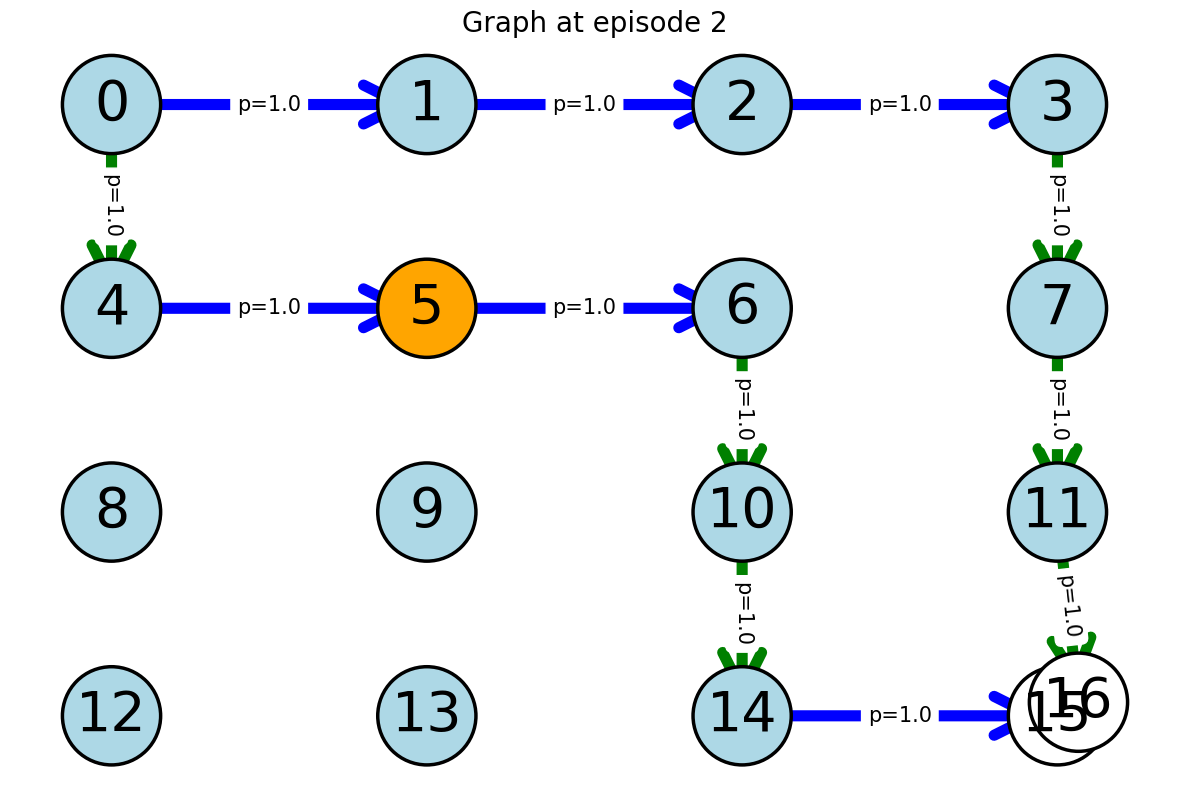

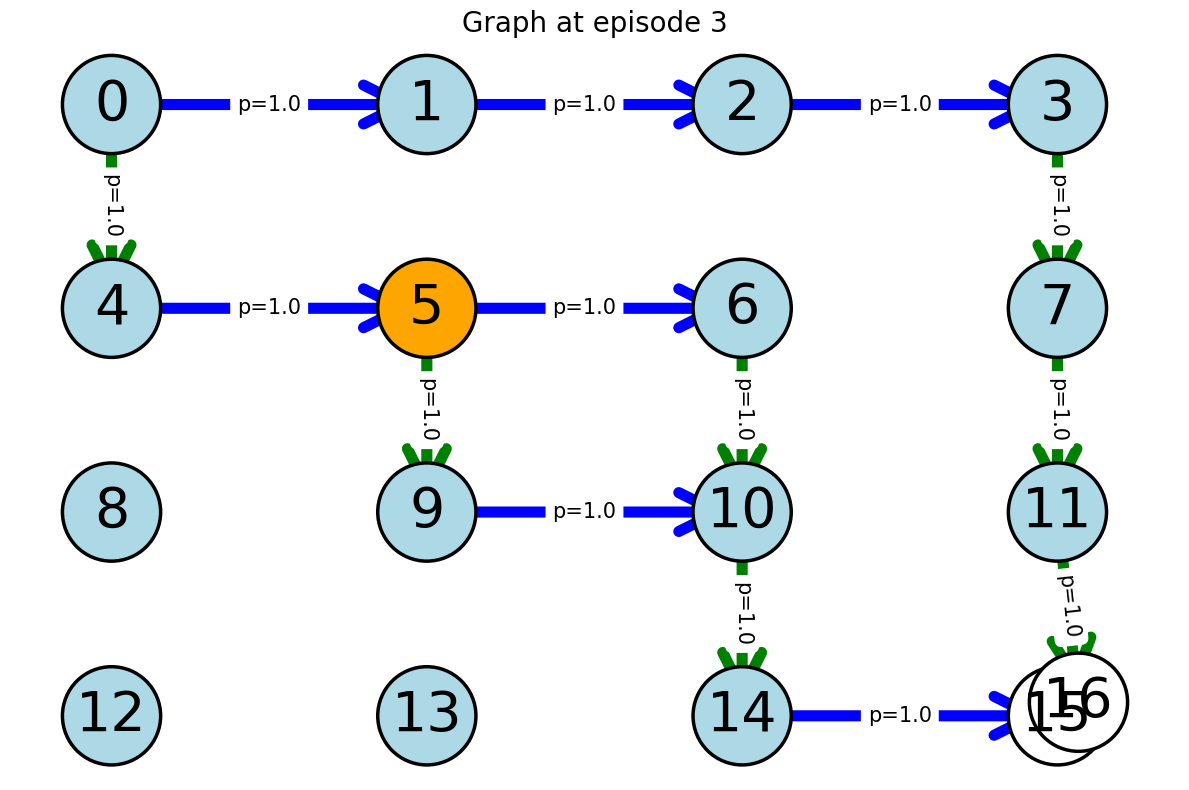

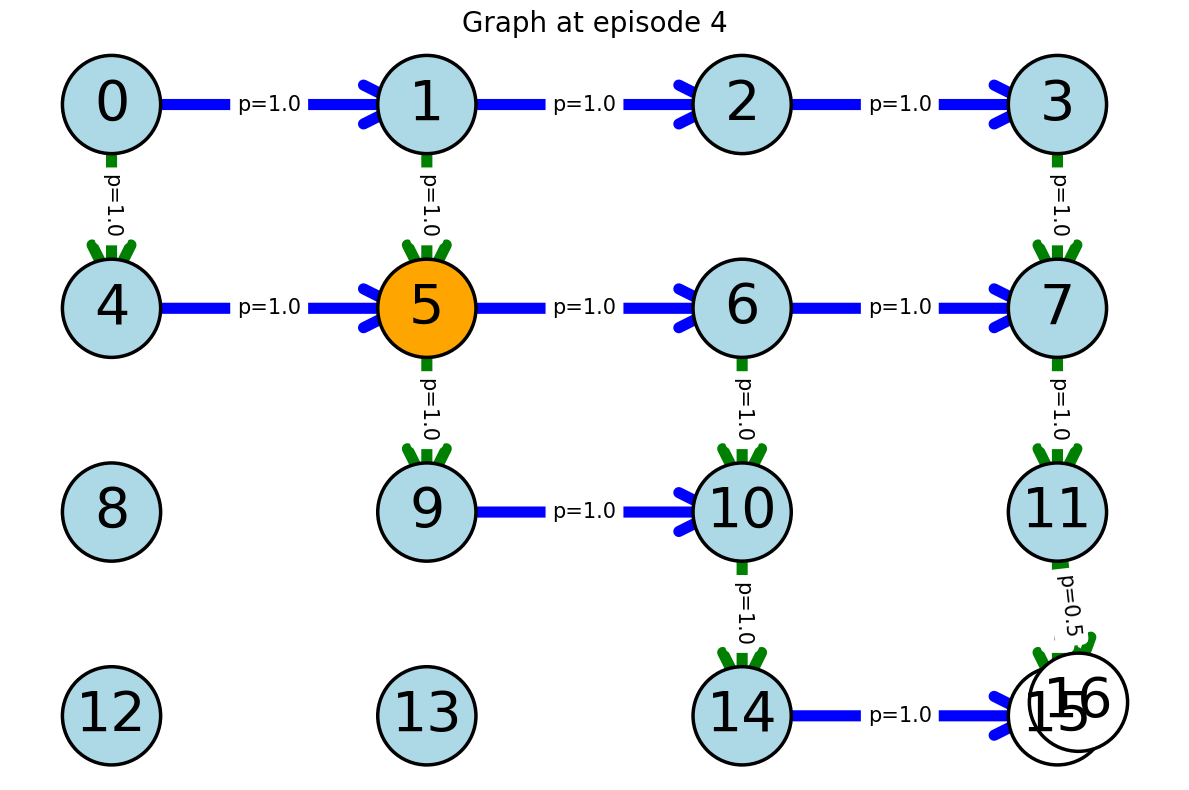

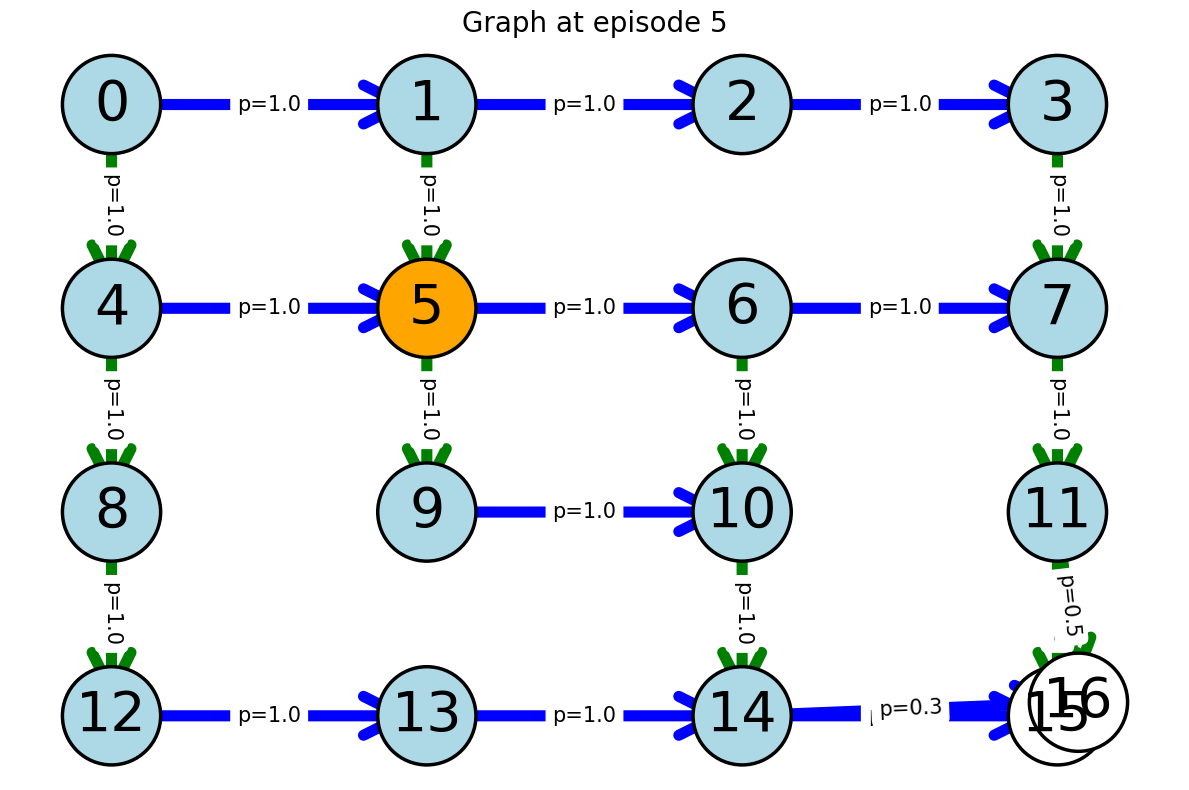

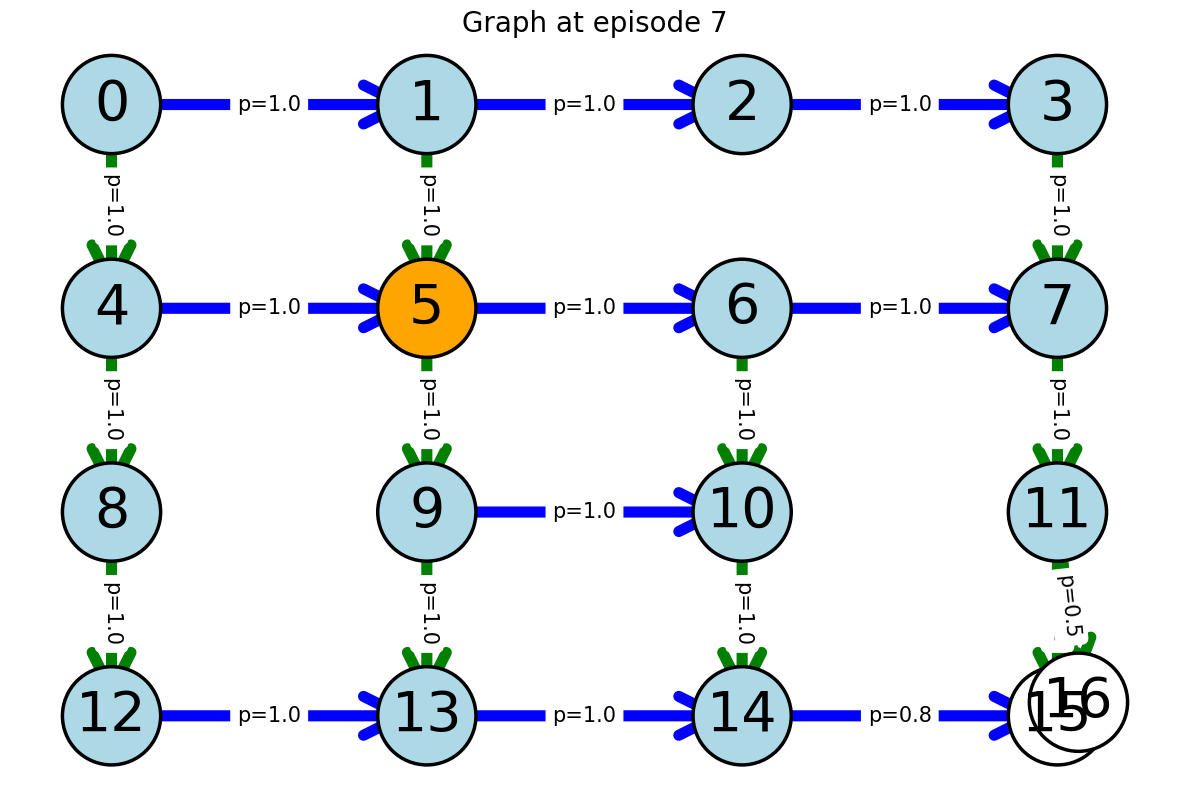

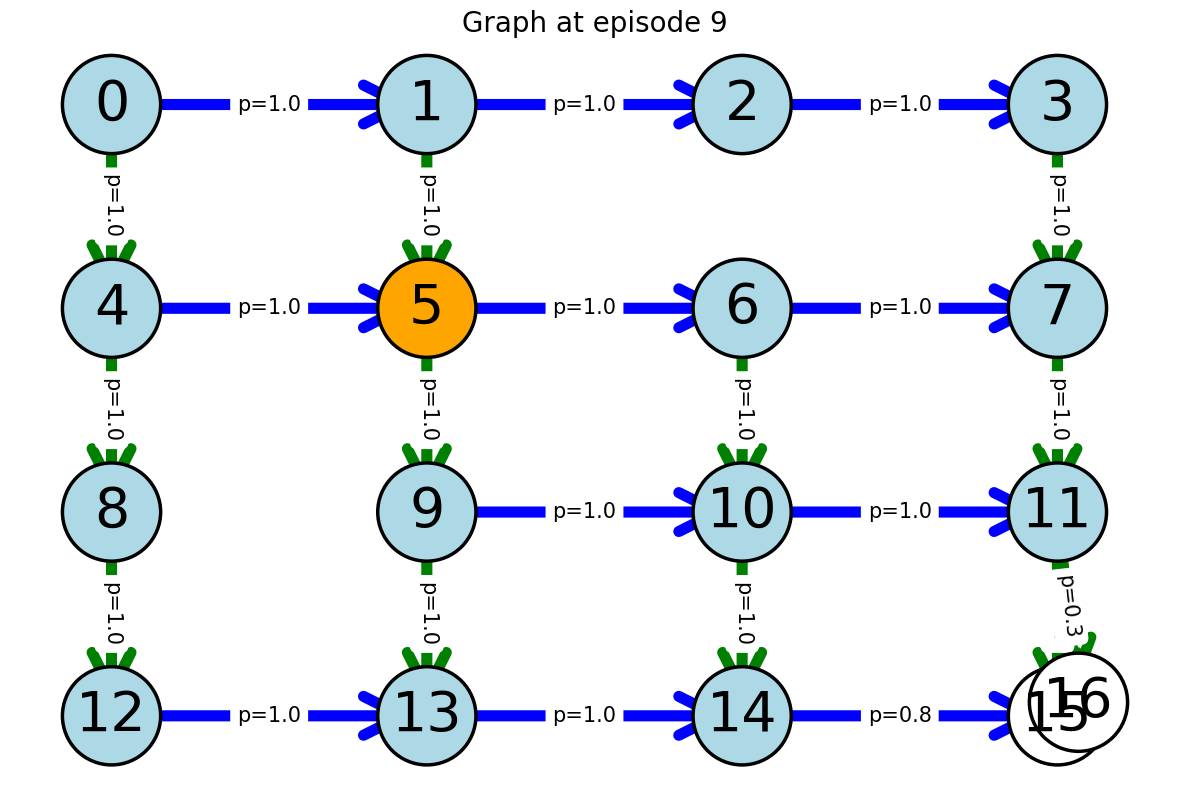

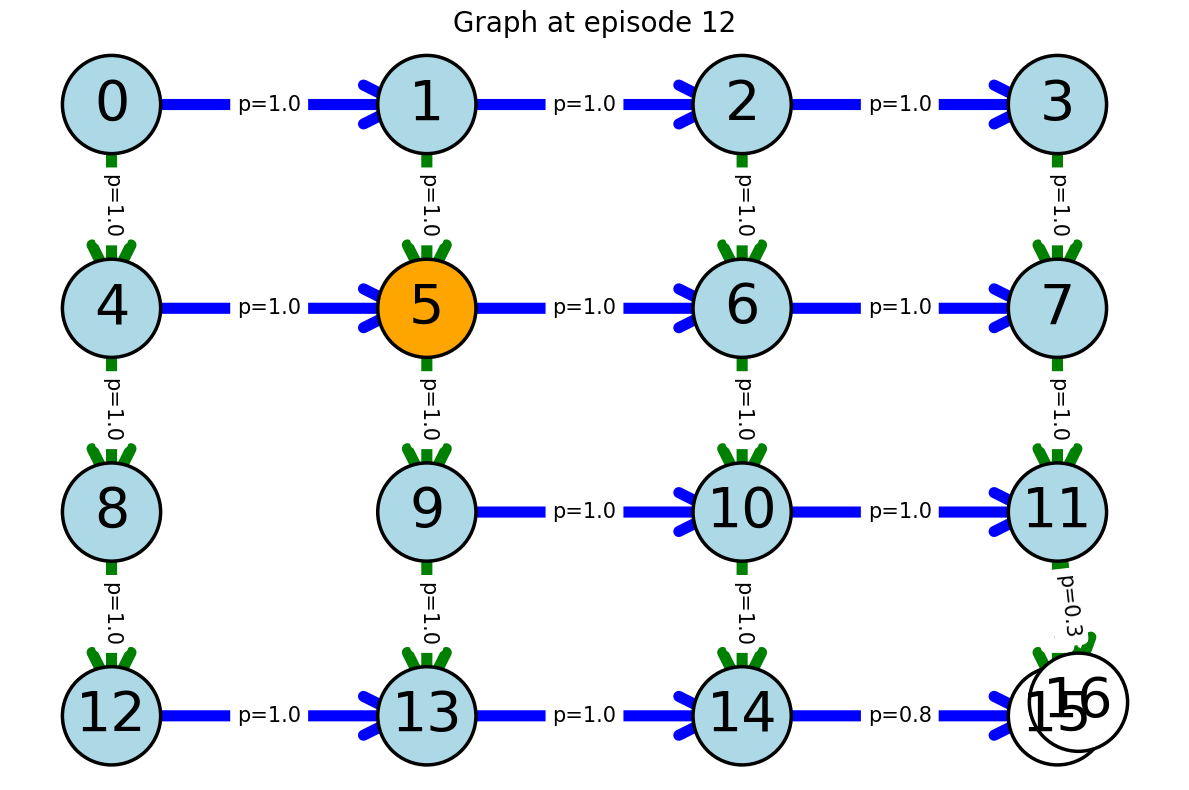

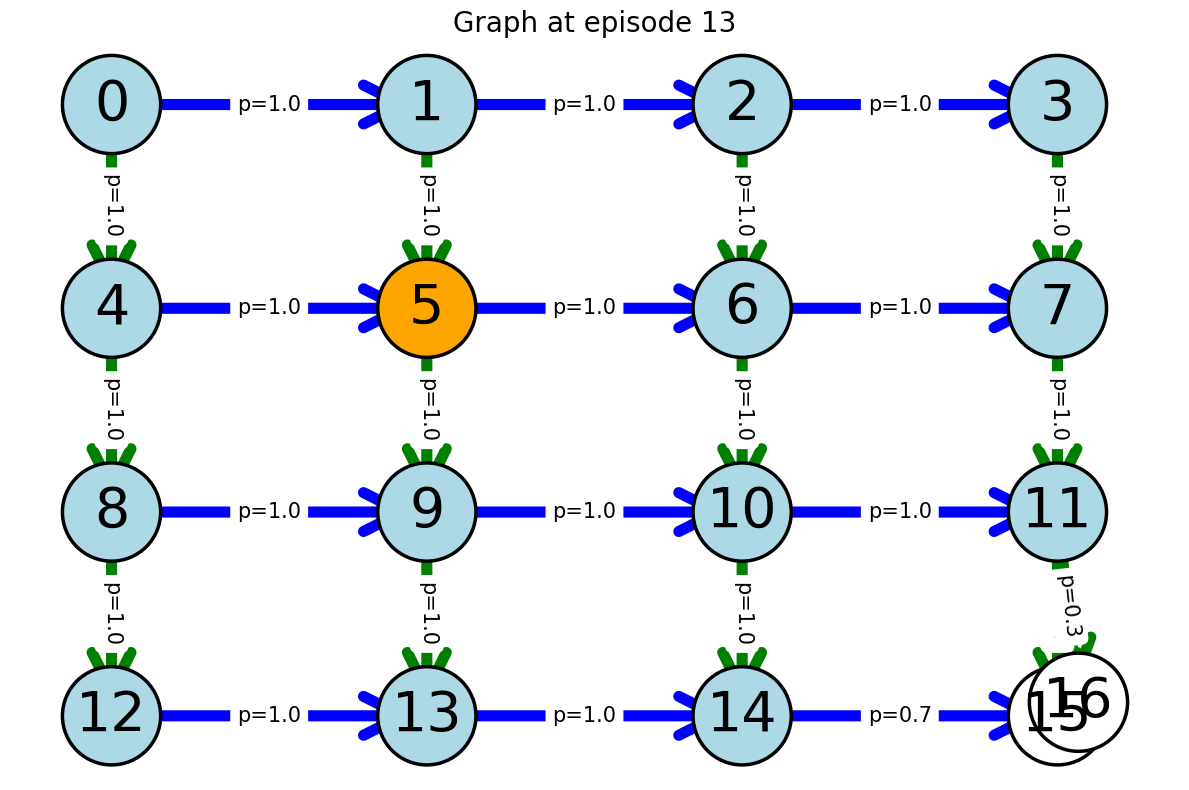

[acq] frames rendered: 9 at episodes [1, 2, 3, 4, 5, 7, 9, 12, 13]
[ext] frames rendered: 0 at episodes []


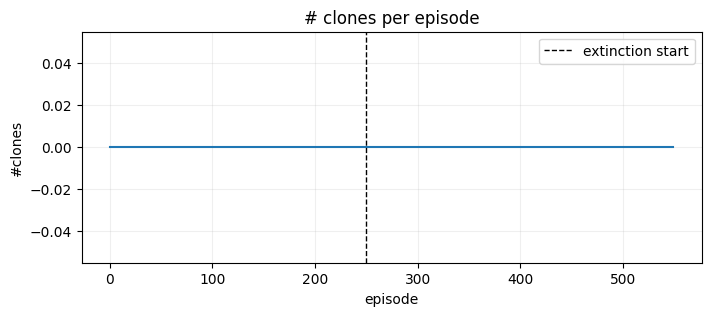

Use show_episode(EP) to re-draw any specific episode.


In [22]:
# ===== Trial-by-trial clone tracking & snapshots (acquisition → extinction) =====
import numpy as np

# ---- knobs ----
CUE         = 5
N_ACQ       = 250
N_EXT       = 300
MAX_STEPS   = 20
THRESH_DET  = 0.10   # lower threshold used only for "change detection"
THRESH_PLOT = 0.30   # visual threshold passed to plot_graph
SAVE_FRAMES = False  # set True to save PNGs for changed episodes

# ---- utilities ----
def num_base_states(env):
    return env.num_unique_states

def clone_ids(agent):
    baseN = num_base_states(agent.env)
    return [i for i in range(agent.n_states) if i >= baseN]

def binary_adj(T, thr):
    A = T.sum(axis=1)  # [S,S]
    return (A >= thr).astype(np.uint8)

def graph_changed(prev_T, prev_map, curr_T, curr_map, thr=THRESH_DET):
    if prev_T is None: return True
    if prev_T.shape != curr_T.shape: return True
    A_prev = binary_adj(prev_T, thr)
    A_curr = binary_adj(curr_T, thr)
    if A_prev.shape != A_curr.shape: return True
    if (A_prev != A_curr).any(): return True
    return prev_map != curr_map

def make_terminals_absorbing_for_plot(T, terminals):
    T = T.copy()
    for t in terminals:
        if t < T.shape[0]:
            T[t, :, :] = 0.0
    return T

def sanitize_for_plot(env, T, eps=1e-12):
    """drop clone nodes with ~zero mass so they don't draw as 'funky' dots."""
    S = T.shape[0]
    out_mass = T.sum(axis=(1,2))
    in_mass  = T.sum(axis=(0,1))
    active = (out_mass + in_mass) > eps
    for cl in list(getattr(env, "clone_dict", {}).keys()):
        if cl >= S or not active[cl]:
            env.clone_dict.pop(cl, None)
    env.reverse_clone_dict = {parent: cl for cl, parent in env.clone_dict.items()}

# ---- run acquisition ----
env = GridEnvRightDownNoSelf(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
agent = CoDAAgent(env, cfg)  # uses your current CoDAConfig `cfg`

with_clones = False
prev_T, prev_map = None, None

# per-episode logs
CLONES_PER_EP   = []   # list of lists of clone ids
NCLONES_PER_EP  = []   # list of ints
CUES_PER_EP     = []   # list of sorted salient_cues
SNAPSHOT_EP     = []   # episode indices where we rendered

for ep in range(1, N_ACQ+1):
    if with_clones:
        (states, actions) = generate_dataset_post_augmentation(env, agent.get_T(), n_episodes=1, max_steps=MAX_STEPS)[0]
    else:
        (states, actions) = generate_dataset(env, n_episodes=1, max_steps=MAX_STEPS)[0]

    agent.update_with_episode(states, actions)
    new = agent.maybe_split()
    if new and not with_clones:
        with_clones = True
        # warm up 1 episode to push mass through new clone edges
        (ws, wa) = generate_dataset_post_augmentation(env, agent.get_T(), n_episodes=1, max_steps=MAX_STEPS)[0]
        agent.update_with_episode(ws, wa)

    T_curr  = agent.get_T().copy()
    map_curr = tuple(sorted(getattr(env, "clone_dict", {}).items()))
    CLONES_PER_EP.append(clone_ids(agent))
    NCLONES_PER_EP.append(len(CLONES_PER_EP[-1]))
    CUES_PER_EP.append(sorted(agent.salient_cues))

    if graph_changed(prev_T, prev_map, T_curr, map_curr, thr=THRESH_DET):
        T_vis = make_terminals_absorbing_for_plot(T_curr, env.rewarded_terminals + env.unrewarded_terminals)
        # do NOT sanitize the very first split frame; sanitize thereafter
        if SNAPSHOT_EP:
            sanitize_for_plot(env, T_vis)
        env.plot_graph(T_vis, niter=ep, threshold=THRESH_PLOT, save=SAVE_FRAMES, savename=f"acq_ep{ep}.png")
        SNAPSHOT_EP.append(ep)
        prev_T, prev_map = T_curr, map_curr

print(f"[acq] frames rendered: {len(SNAPSHOT_EP)} at episodes {SNAPSHOT_EP[:10]}{' ...' if len(SNAPSHOT_EP)>10 else ''}")

# ---- switch to extinction, continue trial-by-trial ----
env2 = GridEnvRightDownNoCue(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
env2.clone_dict = dict(getattr(env, "clone_dict", {}))
env2.reverse_clone_dict = dict(getattr(env, "reverse_clone_dict", {}))
agent.env = env2

prev_T, prev_map = prev_T, prev_map
SNAPSHOT_EP_EXT = []

for ep in range(N_ACQ+1, N_ACQ+N_EXT+1):
    (states, actions) = generate_dataset_post_augmentation(env2, agent.get_T(), n_episodes=1, max_steps=MAX_STEPS)[0]
    agent.update_with_episode(states, actions)
    agent.maybe_merge()

    T_curr  = agent.get_T().copy()
    map_curr = tuple(sorted(getattr(env2, "clone_dict", {}).items()))
    CLONES_PER_EP.append(clone_ids(agent))
    NCLONES_PER_EP.append(len(CLONES_PER_EP[-1]))
    CUES_PER_EP.append(sorted(agent.salient_cues))

    if graph_changed(prev_T, prev_map, T_curr, map_curr, thr=THRESH_DET):
        T_vis = make_terminals_absorbing_for_plot(T_curr, env2.rewarded_terminals + env2.unrewarded_terminals)
        sanitize_for_plot(env2, T_vis)
        env2.plot_graph(T_vis, niter=ep, threshold=THRESH_PLOT, save=SAVE_FRAMES, savename=f"ext_ep{ep}.png")
        SNAPSHOT_EP_EXT.append(ep)
        prev_T, prev_map = T_curr, map_curr

print(f"[ext] frames rendered: {len(SNAPSHOT_EP_EXT)} at episodes {SNAPSHOT_EP_EXT[:10]}{' ...' if len(SNAPSHOT_EP_EXT)>10 else ''}")

# ---- quick line plots (trial-by-trial) ----
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
plt.plot(NCLONES_PER_EP)
plt.axvline(N_ACQ, color='k', ls='--', lw=1, label='extinction start')
plt.title("# clones per episode"); plt.xlabel("episode"); plt.ylabel("#clones"); plt.legend(); plt.grid(alpha=0.2)
plt.show()

# ---- helper to re-plot any specific episode on demand ----
def show_episode(ep_idx, threshold=THRESH_PLOT):
    """Re-draw the graph at a specific episode index (1-based)."""
    assert 1 <= ep_idx <= (N_ACQ+N_EXT), "episode out of range"
    # reconstruct the correct env reference and T at that episode
    use_env = env if ep_idx <= N_ACQ else env2
    T_all = []
    # collect by rerunning quickly with no plotting; cheaper alternative is to store Ts per episode if desired
    print("Re-running quickly to reconstruct T at requested episode...")
    agent_tmp = CoDAAgent(GridEnvRightDownNoSelf(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15]), cfg)
    e = agent_tmp.env
    with_clones = False
    for ep in range(1, ep_idx+1):
        if ep <= N_ACQ:
            if with_clones:
                (s,a) = generate_dataset_post_augmentation(e, agent_tmp.get_T(), n_episodes=1, max_steps=MAX_STEPS)[0]
            else:
                (s,a) = generate_dataset(e, n_episodes=1, max_steps=MAX_STEPS)[0]
            agent_tmp.update_with_episode(s,a)
            if agent_tmp.maybe_split(): with_clones = True
            if ep == N_ACQ and ep_idx > N_ACQ:
                # switch to extinction
                e2 = GridEnvRightDownNoCue(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
                e2.clone_dict = dict(getattr(e, "clone_dict", {})); e2.reverse_clone_dict = dict(getattr(e, "reverse_clone_dict", {}))
                agent_tmp.env = e2; e = e2
        else:
            (s,a) = generate_dataset_post_augmentation(e, agent_tmp.get_T(), n_episodes=1, max_steps=MAX_STEPS)[0]
            agent_tmp.update_with_episode(s,a)
            agent_tmp.maybe_merge()

    T = agent_tmp.get_T().copy()
    T_vis = make_terminals_absorbing_for_plot(T, e.rewarded_terminals + e.unrewarded_terminals)
    sanitize_for_plot(e, T_vis)
    e.plot_graph(T_vis, niter=ep_idx, threshold=threshold, save=False, savename=f"episode_{ep_idx}.png")

print("Use show_episode(EP) to re-draw any specific episode.")